#Pytorch


##mnist

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
from sklearn.datasets import load_boston
from torch import nn
from tqdm.notebook import tqdm
import pandas as pd

%matplotlib inline

In [ ]:
mnist_train = torchvision.datasets.MNIST("./mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor()) 
mnist_val = torchvision.datasets.MNIST("./mnist/",train=False, download=True, transform=torchvision.transforms.ToTensor())

train_dataloader = torch.utils.data.DataLoader(mnist_train, batch_size=128, shuffle=True, num_workers=1) 

val_dataloader = torch.utils.data.DataLoader(mnist_val, batch_size=128, shuffle=True, num_workers=1)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



In [ ]:
def train(model, optimizer, epochs):
  history = pd.DataFrame(columns=['train_loss', 'val_loss', 'train_accuracy', 'val_accuracy'])

  for epoch in range(epochs):
    train_loss = []
    train_accuracy = []
    for x_train, y_train in tqdm(train_dataloader):    
      y_pred = model(x_train)                 
      loss = F.cross_entropy(y_pred, y_train)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      if epoch % 1 == 0:
        train_loss.append(loss.item())
        train_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_train).numpy().tolist())
      
    if epoch % 1 == 0:
      val_loss = []
      val_accuracy = []
      with torch.no_grad():
        for x_val, y_val in tqdm(val_dataloader):

          y_pred_val = model(x_val)
          loss_val = F.cross_entropy(y_pred_val, y_val)
          val_loss.append(loss_val.numpy())
          val_accuracy.extend((torch.argmax(y_pred_val, dim=-1) == y_val).numpy().tolist())

      # сохраняем для графиков
      mean_acc, mean_loss = np.mean(train_accuracy), np.mean(train_loss)
      mean_acc_val, mean_loss_val = np.mean(val_accuracy), np.mean(val_loss)

      history = history.append(pd.Series(
          data=[mean_loss, mean_loss_val, mean_acc, mean_acc_val], 
          index=['train_loss', 'val_loss', 'train_accuracy', 'val_accuracy']),
          ignore_index=True)
      # печатаем метрики
      print(f"Epoch: {epoch}, loss: {mean_loss_val}, accuracy: {mean_acc_val}")
  return history

In [ ]:
def plot_history(history):
  fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8))
  fig.suptitle('History')
  
  ax1.plot(history['train_accuracy'], 'o-', label='train')
  ax1.plot(history['val_accuracy'], 'o-', label='test')
  ax1.legend(loc="upper right")
  ax1.set_ylabel('Accuracy')

  ax2.plot(history['train_loss'], 'o-', label='train')
  ax2.plot(history['val_loss'], 'o-', label='test')
  ax2.legend(loc="upper right")
  ax2.set_xlabel('epochs')
  ax2.set_ylabel('Loss')

  plt.show()

In [ ]:
import seaborn as sns
from sklearn.metrics import f1_score, confusion_matrix

def plot_matrix(conf_matrix):
  plt.figure(figsize=(8, 6))
  sns.heatmap(conf_matrix)

def calc_conf_mat(model, labels):
  n = len(labels)
  confusion_mat = np.zeros((n, n))

  with torch.no_grad():
    for x_val, y_val in tqdm(val_dataloader):
      y_pred = torch.argmax(model(x_val), dim=-1)
      confusion_mat += confusion_matrix(y_val.numpy(), np.array(y_pred), labels=labels)
  return confusion_mat

In [ ]:
model_l1 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 10),
)

optimizer_l1 = torch.optim.SGD(model_l1.parameters(), lr=0.05) 
history = train(model_l1, optimizer_l1, 15)

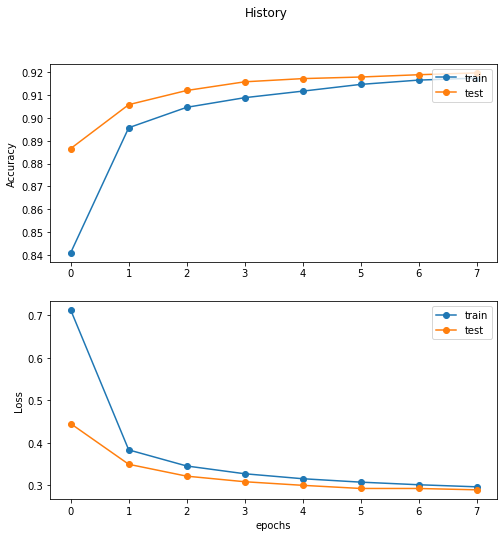

In [ ]:
plot_history(history)

In [ ]:
model_l2 = nn.Sequential(
    nn.Flatten(),             # превращает матрицу 28х28 в тензор \ вектор размером 784
    nn.Linear(28 * 28, 128),  # преобразует тезор размера 784 в вектор 128
    nn.ReLU(),                # передаточная функция
    nn.Linear(128, 10),       # вызодной слой 128 в 10
)
optimizer_l2 = torch.optim.SGD(model_l2.parameters(), lr=0.05) 
history = train(model_l2, optimizer_l2, 15)

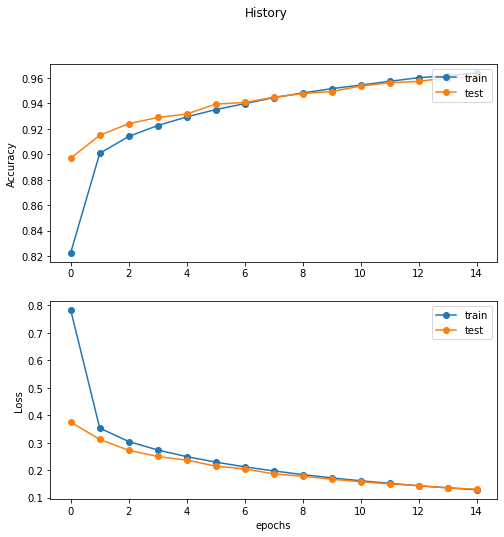

In [ ]:
plot_history(history)

In [ ]:
model_l3 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 256),
    nn.ReLU(),        
    nn.Linear(256, 128), 
    nn.Tanh(),
    nn.Linear(128, 10)
)
optimizer_l3 = torch.optim.SGD(model_l3.parameters(), lr=0.05) 
history = train(model_l3, optimizer_l3, 15)

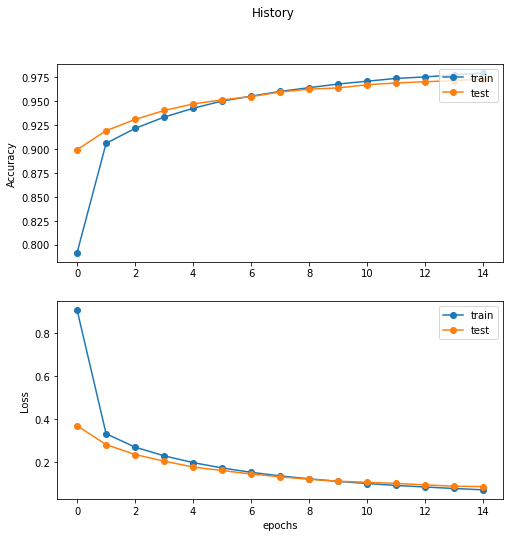

In [ ]:
plot_history(history)

Что будет если заменить ReLU -> LogSoftmax

In [ ]:
model_l3_softmax = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 256),
    nn.ReLU(),        
    nn.Linear(256, 128), 
    nn.LogSoftmax(),
    nn.Linear(128, 10)
)
optimizer_l3_softmax = torch.optim.SGD(model_l3.parameters(), lr=0.05) 
history = train(model_l3_softmax, optimizer_l3_softmax, 15)

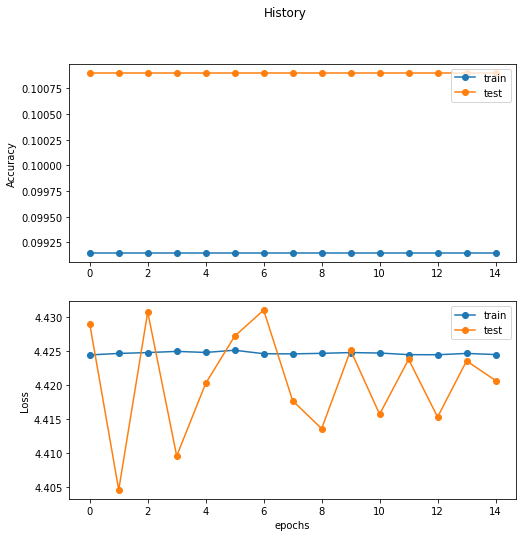

In [ ]:
plot_history(history)

##fashoinmnist

In [ ]:
mnist_train = torchvision.datasets.FashionMNIST("./fashionmnist/", train=True, download=True, transform=torchvision.transforms.ToTensor()) 
mnist_val = torchvision.datasets.FashionMNIST("./fashionmnist/",train=False, download=True, transform=torchvision.transforms.ToTensor())

train_dataloader = torch.utils.data.DataLoader(mnist_train, batch_size=128, shuffle=True, num_workers=1) 

val_dataloader = torch.utils.data.DataLoader(mnist_val, batch_size=128, shuffle=True, num_workers=1)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./fashionmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./fashionmnist/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./fashionmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./fashionmnist/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./fashionmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./fashionmnist/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./fashionmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./fashionmnist/FashionMNIST/raw



In [ ]:
model_l1 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 10),
)
optimizer_l1 = torch.optim.SGD(model_l1.parameters(), lr=0.05)
history = train(model_l1, optimizer_l1, 15)

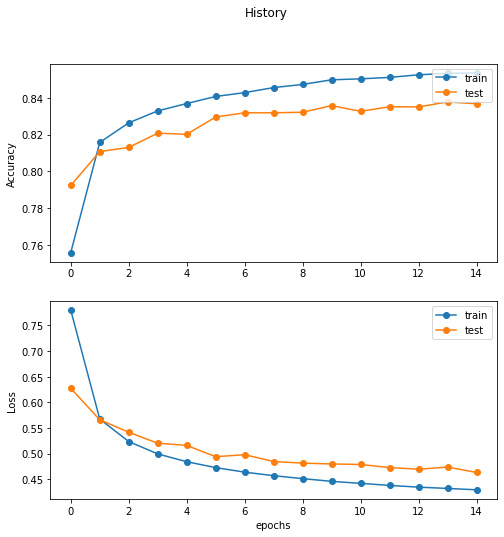

In [ ]:
plot_history(history)

  0%|          | 0/79 [00:00<?, ?it/s]

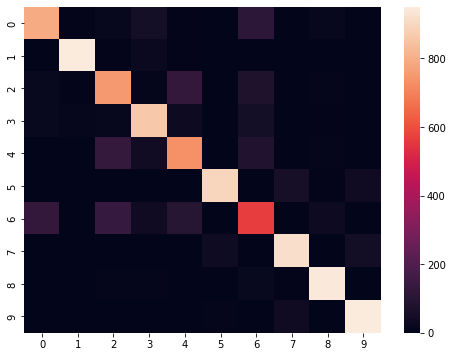

In [ ]:
plot_matrix(calc_conf_mat(model_l1, [i for i in range(10)]))

In [ ]:
model_l2 = nn.Sequential(
    nn.Flatten(), 
    nn.Linear(28 * 28, 128), 
    nn.ReLU(),      
    nn.Linear(128, 10),   
)
optimizer_l2 = torch.optim.SGD(model_l2.parameters(), lr=0.05) 
history = train(model_l2, optimizer_l2, 15)

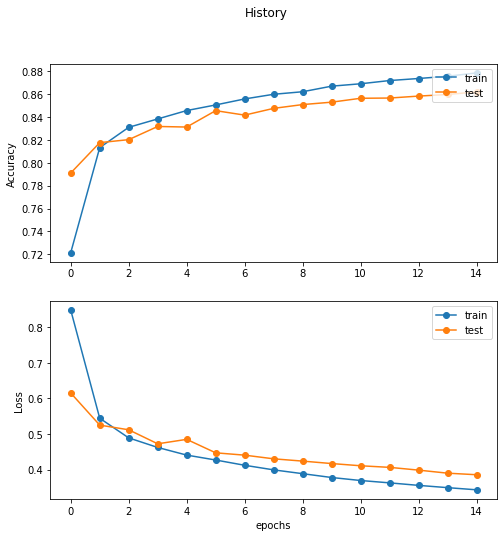

In [ ]:
plot_history(history)

  0%|          | 0/79 [00:00<?, ?it/s]

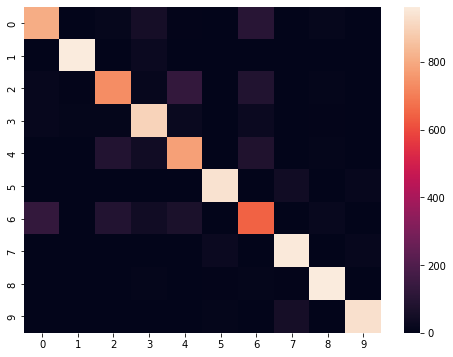

In [ ]:
plot_matrix(calc_conf_mat(model_l2, [i for i in range(10)]))

In [ ]:
model_l3 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 256),
    nn.ReLU(),        
    nn.Linear(256, 128), 
    nn.ReLU(),
    nn.Linear(128, 10)
)
optimizer_l3 = torch.optim.SGD(model_l3.parameters(), lr=0.1) 
history = train(model_l3, optimizer_l3, 15)

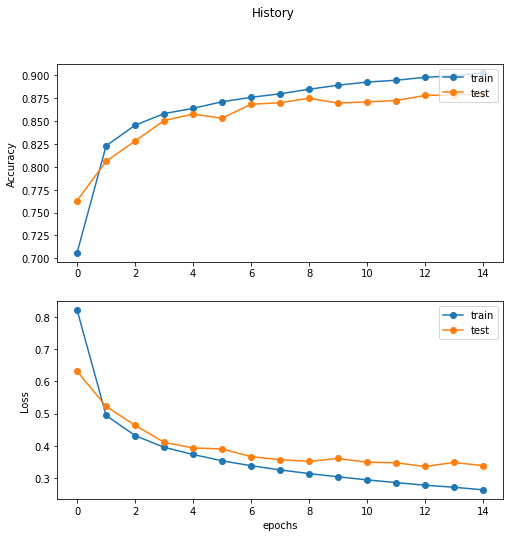

In [ ]:
plot_history(history)

  0%|          | 0/79 [00:00<?, ?it/s]

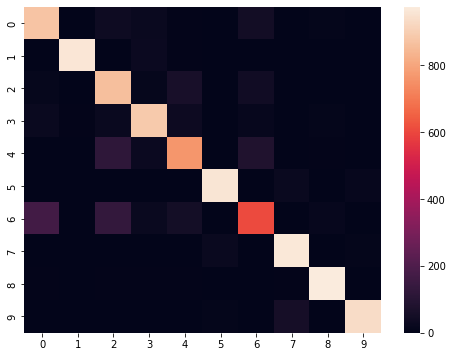

In [ ]:
plot_matrix(calc_conf_mat(model_l3, [i for i in range(10)]))

##cifar-10

In [ ]:
mnist_train = torchvision.datasets.CIFAR10("./cifar10/", train=True, download=True, transform=torchvision.transforms.ToTensor()) 
mnist_val = torchvision.datasets.CIFAR10("./cifar10/",train=False, download=True, transform=torchvision.transforms.ToTensor())

train_dataloader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True, num_workers=1) 

val_dataloader = torch.utils.data.DataLoader(mnist_val, batch_size=64, shuffle=True, num_workers=1)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
model_l1 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(32 * 32 * 3, 10),
)
optimizer_l1 = torch.optim.SGD(model_l1.parameters(), lr=0.01) 
history = train(model_l1, optimizer_l1, 15)

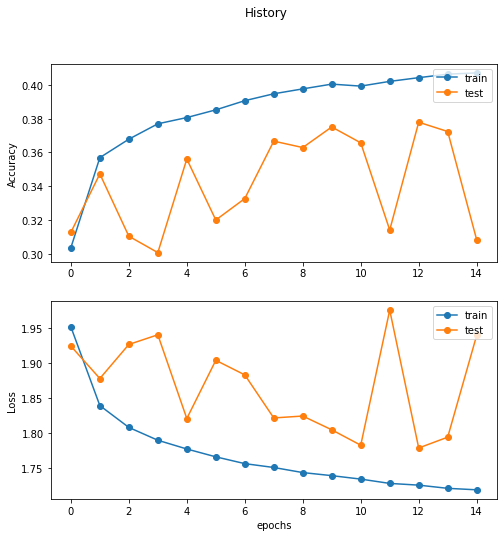

In [ ]:
plot_history(history)

  0%|          | 0/157 [00:00<?, ?it/s]

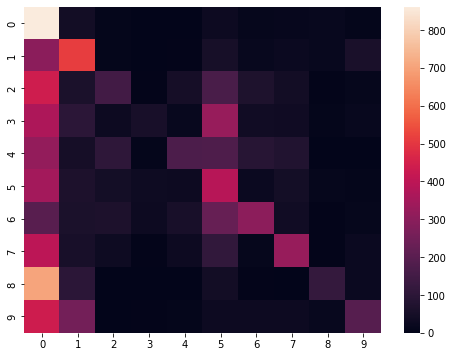

In [ ]:
plot_matrix(calc_conf_mat(model_l1, [i for i in range(10)]))

In [ ]:
model_l2 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(32 * 32 * 3, 256),
    nn.ReLU(),  
    nn.Linear(256, 10),
)
optimizer_l2 = torch.optim.SGD(model_l2.parameters(), lr=0.05) 
history = train(model_l2, optimizer_l2, 15)

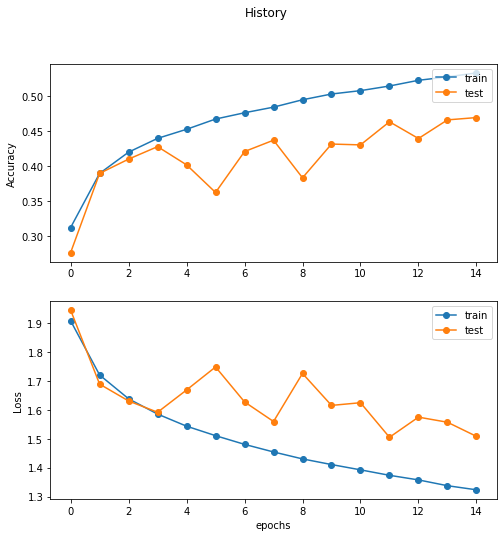

In [ ]:
plot_history(history)

  0%|          | 0/157 [00:00<?, ?it/s]

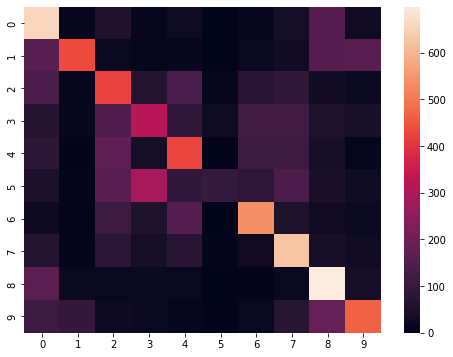

In [ ]:
plot_matrix(calc_conf_mat(model_l2, [i for i in range(10)]))

In [ ]:
32 * 32 * 3 / 2

1536.0

In [ ]:
model_l3 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(32 * 32 * 3, 1024),
    nn.ReLU(),        
    nn.Linear(1024, 512), 
    nn.ReLU(), 
    nn.Linear(512, 256), 
    nn.ReLU(), 
    nn.Linear(256, 10)
)
optimizer_l3 = torch.optim.SGD(model_l3.parameters(), lr=0.05) 
history = train(model_l3, optimizer_l3, 15)

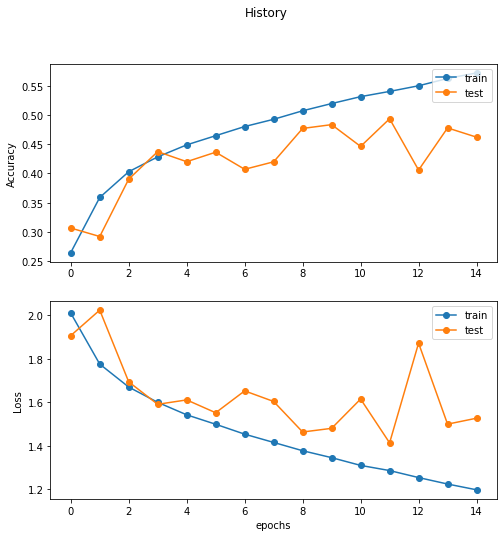

In [ ]:
plot_history(history)

  0%|          | 0/157 [00:00<?, ?it/s]

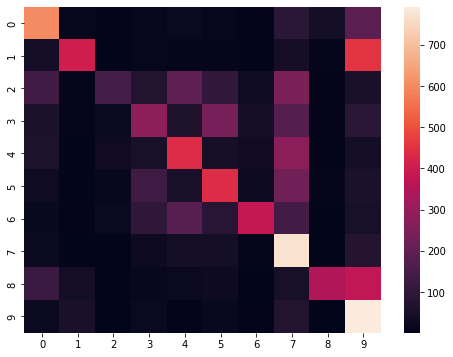

In [ ]:
plot_matrix(calc_conf_mat(model_l3, [i for i in range(10)]))